In [1]:
using ITensors, ITensorMPS
using Plots
using Random
using Statistics
using LinearAlgebra



In [2]:
"""
Creates a random MPS for a spin-1/2 chain of length L.
The initial state is antiferromagnetic, which helps DMRG converge.
"""
function create_MPS(L::Int)
    sites = siteinds("S=1/2", L; conserve_qns=true)
    initial_state = [isodd(i) ? "Up" : "Dn" for i in 1:L]
    ψ₀ = randomMPS(sites, initial_state)
    return ψ₀, sites
end

create_MPS

In [3]:
"""
Creates a weighted adjacency matrix
"""
function create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)
    if σ == 0.0
        A = ones(Float64, N, N)
        A -= Matrix{Float64}(I, N, N)
        return A
    end

    A = zeros(Float64, N, N)
    for i in 1:N, j in (i+1):N
        weight = μ + σ * randn()
        A[i, j] = A[j, i] = weight
    end
    return A
end

function create_weighted_adj_mat_lin(N::Int, σ::Float64; μ::Float64=1.0)
    if σ == 0.0
        A = zeros(Float64, N, N)
        for i in 1:N-1
            A[i, i+1] = A[i+1, i] = μ
        end
        return A
    end

    A = zeros(Float64, N, N)
    for i in 1:N-1
        weight = μ + σ * randn()
        A[i, i+1] = A[i+1, i] = weight
    end
    return A
end

create_weighted_adj_mat_lin (generic function with 1 method)

In [4]:
"""
Creates the MPO for the XXZ Hamiltonian on a graph with weighted interactions.
"""
function create_weighted_xxz_mpo(N::Int, adj_mat, sites; J::Float64=1.0, Δ::Float64=1.0)
    ampo = OpSum()
    for i in 1:N-1
        for j in i+1:N
            coupling_strength = adj_mat[i, j]
            if coupling_strength != 0.0
                ampo += coupling_strength * (J / 2), "S+", i, "S-", j
                ampo += coupling_strength * (J / 2), "S-", i, "S+", j
                ampo += coupling_strength * (J * Δ), "Sz", i, "Sz", j
            end
        end
    end
    return MPO(ampo, sites)
end

create_weighted_xxz_mpo

In [11]:
function plot_bond_dim()
    N_range = 10:1:75
    num_sweeps = 30
    max_bond_dim = 200
    cutoff = 1E-10
    σ = 0.002

    bond_dims = Float64[]

    for N in N_range
        ψ₀, sites = create_MPS(N) 
        adj_mat = create_weighted_adj_mat_lin(N, σ)

        H_mpo = create_weighted_xxz_mpo(N, adj_mat, sites; J=-0.5, Δ=0.5)

        sweeps = Sweeps(num_sweeps)
        setmaxdim!(sweeps, max_bond_dim)
        setcutoff!(sweeps, cutoff)

        energy, ψ_gs = dmrg(H_mpo, ψ₀, sweeps; outputlevel=0)
        
        final_bond_dim = maxlinkdim(ψ_gs)
        push!(bond_dims, final_bond_dim)

        println("Completed N = $N. Energy = $(round(energy, digits=4)), Max Bond Dim = $final_bond_dim")
    end

    plt = plot(
        title="Saturated Bond Dimension for an Average Graph with N Nodes",
        xlabel="Number of Nodes",
        ylabel="Average Bond Dimension Required",
        legend=false,
        gridalpha=0.3,
        framestyle=:box
    )

    plot!(plt, N_range, bond_dims,
        lw=2,
        marker=:circle,
        markersize=4,
        markerstrokecolor=:auto,
        markercolor=:coral,
        linecolor=:deepskyblue
    )
    
    ylims!(plt, 0, ceil(Int, maximum(bond_dims))+1)

    return plt
end

plot_bond_dim (generic function with 1 method)

Completed N = 10. Energy = -1.2737, Max Bond Dim = 18
Completed N = 11. Energy = -1.4015, Max Bond Dim = 18
Completed N = 12. Energy = -1.5478, Max Bond Dim = 24
Completed N = 13. Energy = -1.678, Max Bond Dim = 23
Completed N = 14. Energy = -1.8209, Max Bond Dim = 26
Completed N = 15. Energy = -1.9537, Max Bond Dim = 26
Completed N = 16. Energy = -2.0975, Max Bond Dim = 27
Completed N = 17. Energy = -2.2258, Max Bond Dim = 29
Completed N = 18. Energy = -2.3692, Max Bond Dim = 31
Completed N = 19. Energy = -2.5045, Max Bond Dim = 32
Completed N = 20. Energy = -2.642, Max Bond Dim = 33
Completed N = 21. Energy = -2.7768, Max Bond Dim = 34
Completed N = 22. Energy = -2.9176, Max Bond Dim = 37
Completed N = 23. Energy = -3.0517, Max Bond Dim = 37
Completed N = 24. Energy = -3.1908, Max Bond Dim = 41
Completed N = 25. Energy = -3.3282, Max Bond Dim = 40
Completed N = 26. Energy = -3.4683, Max Bond Dim = 43
Completed N = 27. Energy = -3.6023, Max Bond Dim = 42
Completed N = 28. Energy = -3.

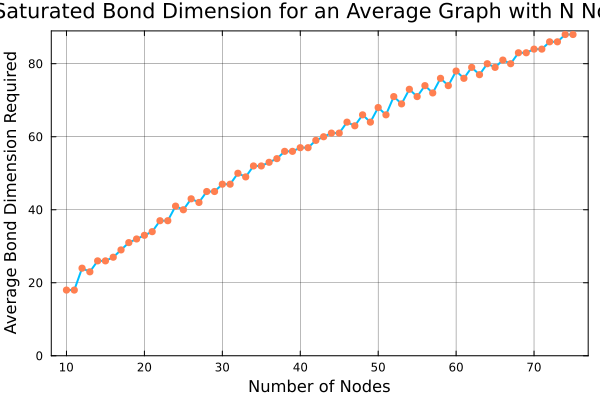

In [12]:
plt = plot_bond_dim();
display(plt)

In [ ]:
N_range = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


energies00 = [-5.9375, -7.1875, -8.625, -10.125, -11.8125, -13.5625, -15.5, -17.5, -19.6875, -21.9375, -24.375, -26.875, -29.5625, -32.3125, -35.25, -38.25, -41.4375, -44.6875, -48.125, -51.625, -55.3125, -59.0625, -63.0, -67.0, -71.1875, -75.4375, -79.875, -84.375, -89.0625, -93.8125, -98.75, -103.75, -108.9375, -114.1875, -119.625, -125.125, -130.8125, -136.5625, -142.5, -148.5, -154.6875, -160.9375, -167.375, -173.875, -180.5625, -187.3125, -194.25, -201.25, -208.4375, -215.6875, -223.125, -230.625, -238.3125, -246.0625, -254.0, -262.0, -270.1875, -278.4375, -286.875, -295.375, -304.0625, -312.8125, -321.75, -330.75, -339.9375, -349.1875]
bond_dimensions00 = [6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 18, 19, 19, 20, 19, 20, 20, 21, 20, 21, 21, 22, 21, 22, 22, 23, 22, 23, 23, 24, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 25, 26, 26, 26, 26, 27, 26, 27, 27]

energies0002 = [-5.9381, -7.1862, -8.6268, -10.1192, -11.8131, -13.5613, -15.5016, -17.5001, -19.6929, -21.939, -24.3763, -26.8812, -29.5626, -32.3138, -35.2472, -38.257, -41.4353, -44.6849, -48.1134, -51.6149, -55.3029, -59.0681, -63.0091, -67.003, -71.191, -75.4373, -79.8687, -84.3811, -89.0624, -93.822, -98.7523, -103.7482, -108.9405, -114.1846, -119.617, -125.1216, -130.8123, -136.5705, -142.5006, -148.5022, -154.6964, -160.9277, -167.3694, -173.8839, -180.5552, -187.3209, -194.25, -201.2473, -208.441, -215.6805, -223.1142, -230.6293, -238.2954, -246.0564, -254.0174, -262.0061, -270.1767, -278.4463, -286.8926, -295.3652, -304.0641, -312.8107, -321.7533, -330.7379, -339.9279, -349.1854]
bond_dimensions0002 = [18, 17, 24, 22, 25, 24, 23, 27, 26, 22, 29, 23, 22, 27, 22, 15, 15, 20, 16, 17, 16, 17, 17, 19, 18, 21, 19, 19, 22, 20, 20, 20, 22, 20, 24, 21, 22, 21, 22, 22, 22, 23, 23, 22, 23, 25, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 25, 26, 26, 26, 26, 27, 27, 27, 27]

energies0001 = [-5.9383, -7.1871, -8.6273, -10.1231, -11.8111, -13.5616, -15.5013, -17.4985, -19.689, -21.9373, -24.3748, -26.876, -29.5636, -32.3133, -35.2463, -38.2514, -41.4382, -44.6923, -48.1272, -51.6255, -55.3136, -59.0629, -62.9976, -67.0006, -71.1915, -75.4422, -79.8687, -84.3744, -89.0639, -93.8121, -98.7521, -103.7466, -108.949, -114.1889, -119.6256, -125.1253, -130.8165, -136.5637, -142.4994, -148.5047, -154.6784, -160.9428, -167.374, -173.8745, -180.5629, -187.3124, -194.2458, -201.2514, -208.4411, -215.6906, -223.1222, -230.6289, -238.3113, -246.0639, -253.9968, -261.9966, -270.1961, -278.4339, -286.8694, -295.3663, -304.0622, -312.8162, -321.7467, -330.7488, -339.9301, -349.1917]
bond_dimensions0001 = [14, 13, 13, 12, 13, 11, 14, 12, 15, 11, 12, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 18, 19, 19, 20, 19, 20, 20, 21, 20, 21, 21, 22, 21, 22, 22, 23, 22, 23, 23, 24, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 25, 26, 26, 26, 26, 27, 26, 27, 27]





energies00lin = [-1.2734, -1.403, -1.5472, -1.678, -1.8213, -1.953, -2.0955, -2.2278, -2.3697, -2.5026, -2.644, -2.7773, -2.9184, -3.052, -3.1927, -3.3266, -3.4671, -3.6013, -3.7415, -3.8759, -4.0159, -4.1505, -4.2904, -4.4251, -4.5648, -4.6997, -4.8393, -4.9743, -5.1137, -5.2488, -5.3882, -5.5234, -5.6627, -5.798, -5.9371, -6.0725, -6.2116, -6.3471, -6.4861, -6.6216, -6.7606, -6.8962, -7.0351, -7.1707, -7.3096, -7.4453, -7.5841, -7.7198, -7.8586, -7.9944, -8.1331, -8.2689, -8.4075, -8.5435, -8.682, -8.818, -8.9565, -9.0925, -9.231, -9.3671, -9.5055, -9.6416, -9.78, -9.9161, -10.0546, -10.1907]
bond_dimensions00lin = [18, 18, 24, 23, 26, 26, 27, 29, 31, 32, 33, 34, 37, 37, 41, 40, 43, 42, 45, 45, 47, 47, 50, 49, 51, 52, 53, 54, 56, 56, 57, 57, 59, 60, 61, 61, 63, 63, 66, 64, 68, 66, 71, 69, 73, 71, 74, 72, 76, 74, 78, 75, 79, 77, 79, 78, 81, 80, 83, 82, 84, 84, 86, 86, 88, 88]

energies0001lin = [-1.2734, -1.4029, -1.5473, -1.6778, -1.8207, -1.9532, -2.0954, -2.2276, -2.3697, -2.503, -2.6435, -2.7764, -2.9183, -3.0517, -3.1928, -3.326, -3.4678, -3.6016, -3.7415, -3.875, -4.0165, -4.1502, -4.2905, -4.424, -4.5647, -4.6973, -4.8386, -4.9741, -5.1127, -5.2487, -5.3885, -5.5228, -5.6632, -5.7976, -5.9373, -6.0744, -6.2119, -6.3472, -6.4844, -6.6207, -6.7611, -6.8947, -7.0356, -7.1704, -7.3108, -7.4481, -7.5836, -7.7217, -7.8583, -7.9936, -8.1327, -8.2691, -8.4081, -8.5426, -8.68, -8.8193, -8.9578, -9.0935, -9.2315, -9.3677, -9.5055, -9.6402, -9.7799, -9.9146, -10.0533, -10.1907]
bond_dimensions0001lin = [18, 18, 24, 23, 26, 26, 27, 29, 31, 32, 33, 34, 37, 37, 41, 40, 43, 42, 45, 45, 47, 47, 50, 49, 51, 52, 53, 54, 56, 56, 57, 57, 59, 60, 61, 61, 63, 63, 66, 64, 68, 66, 71, 69, 73, 70, 74, 72, 76, 74, 78, 75, 78, 77, 80, 79, 81, 80, 83, 83, 84, 84, 86, 86, 88, 88]

energies0002lin = [-1.2737, -1.4015, -1.5478, -1.678, -1.8209, -1.9537, -2.0975, -2.2258, -2.3692, -2.5045, -2.642, -2.7768, -2.9176, -3.0517, -3.1908, -3.3282, -3.4683, -3.6023, -3.7423, -3.8736, -4.017, -4.1523, -4.2919, -4.4239, -4.5605, -4.7009, -4.8394, -4.974, -5.1147, -5.2519, -5.3888, -5.5259, -5.6609, -5.7964, -5.9378, -6.0711, -6.2135, -6.3471, -6.4885, -6.6219, -6.7615, -6.8967, -7.0353, -7.1719, -7.31, -7.4459, -7.5841, -7.7204, -7.858, -7.9918, -8.1343, -8.2682, -8.41, -8.5437, -8.6838, -8.8194, -8.9606, -9.0897, -9.2283, -9.3664, -9.5071, -9.6441, -9.7815, -9.9189, -10.0552, -10.1912]
bond_dimensions0002lin = [18, 18, 24, 23, 26, 26, 27, 29, 31, 32, 33, 34, 37, 37, 41, 40, 43, 42, 45, 45, 47, 47, 50, 49, 52, 52, 53, 54, 56, 56, 57, 57, 59, 60, 61, 61, 64, 63, 66, 64, 68, 66, 71, 69, 73, 71, 74, 72, 76, 74, 78, 76, 79, 77, 80, 79, 81, 80, 83, 83, 84, 84, 86, 86, 88, 88]




66-element Vector{Int64}:
 14
 13
 13
 12
 13
 11
 14
 12
 15
 11
 12
 11
 12
  ⋮
 25
 25
 26
 25
 26
 26
 26
 26
 27
 26
 27
 27

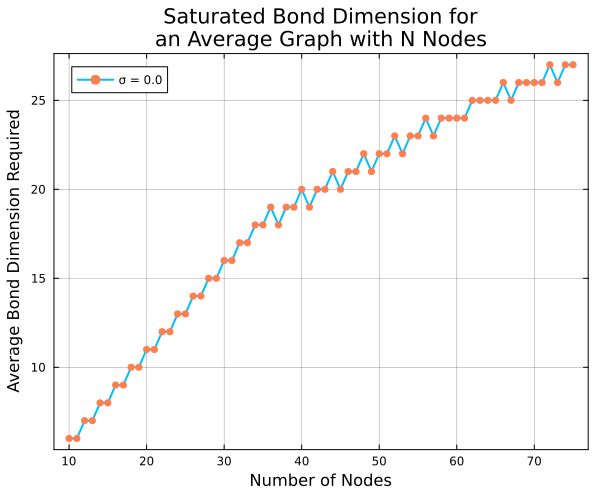

In [8]:
"""
alternative method of making the title appear correctly
using Plots.Measures # Add this to the top of your script

plot(
    # ... your data ...
    title="My Long Title\nOn Two Lines",
    top_margin=10mm # Adds 10 millimeters of space at the top
)
"""
    
    plt = plot(
        size=(600, 500), # default is 600, 400
        title="Saturated Bond Dimension for\nan Average Graph with N Nodes",
        xlabel="Number of Nodes",
        ylabel="Average Bond Dimension Required",
        legend=true,
        gridalpha=0.2,
        framestyle=:box
    )

    plot!(plt, N_range, bond_dimensions00,
        label="σ = 0.0",
        lw=2,
        marker=:circle,
        markersize=4,
        markerstrokecolor=:auto,
        markercolor=:coral,
        linecolor=:deepskyblue
    )




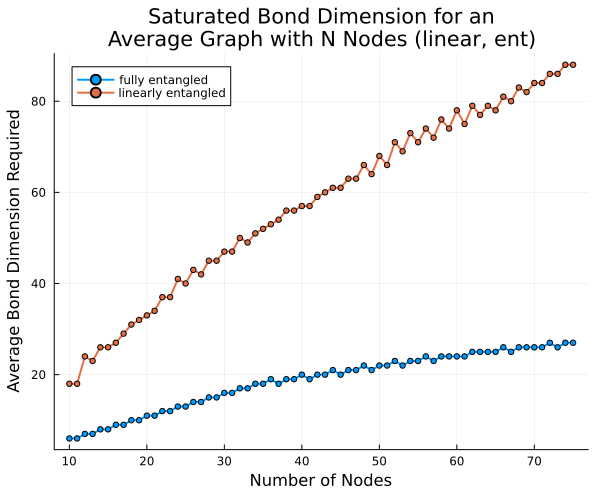

In [9]:
plot(N_range, bond_dimensions00,
    size=(600, 500), # default is 600, 400
    label="fully entangled",
    linewidth=2,
    marker=:circle,
    markersize=3,
    xlabel="Number of Nodes",
    ylabel="Average Bond Dimension Required",
    title="Saturated Bond Dimension for an\nAverage Graph with N Nodes (linear, ent)",
    legend=:topleft)

plot!(N_range, bond_dimensions00lin,
    label="linearly entangled",
    linewidth=2,
    marker =:circle,
    markersize = 3,
    )

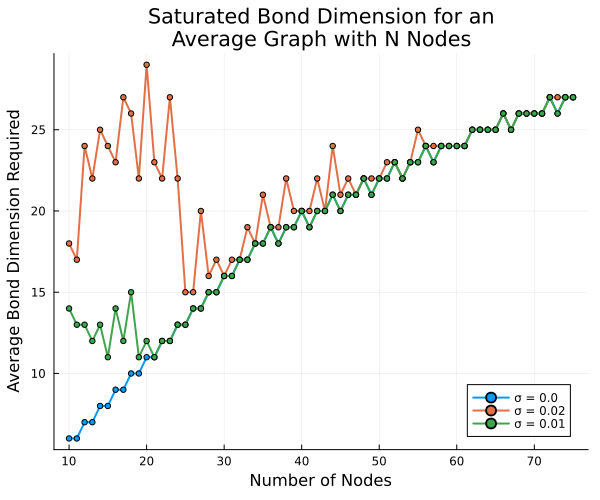

In [10]:
plot(N_range, bond_dimensions00,
    size=(600, 500), # default is 600, 400
    label="σ = 0.0",
    linewidth=2,
    marker=:circle,
    markersize=3,
    xlabel="Number of Nodes",
    ylabel="Average Bond Dimension Required",
    title="Saturated Bond Dimension for an\nAverage Graph with N Nodes",
    legend=:bottomright)

plot!(N_range, bond_dimensions0002,
    label="σ = 0.02",
    linewidth=2,
    marker =:circle,
    markersize = 3,
    )

plot!(N_range, bond_dimensions0001,
    label="σ = 0.01",
    linewidth=2,
    marker =:circle,
    markersize = 3,
    )